# Handling distractor interference in mixed and fixed search 
### A. A. Hanne, J. Tünnermann & A. Schubö

Fitting Bayesian Generalized Linear Mixed Models using the Python package Bambi.
Citation: Capretto, T., Piho, C., Kumar, R., Westfall, J., Yarkoni, T., & Martin, O. A. (2022). Bambi: A Simple Interface for Fitting Bayesian Linear Models in Python. Journal of Statistical Software, 103(15). https://doi.org/10.18637/jss.v103.i15

GitHub: https://bambinos.github.io/bambi/

The analyses were performed with a Bambi version installed from 
https://github.com/GStechschulte/bambi.git@8fa47aa, Python version 3.9.18 and PyMC version 5.8.2.

Due to the stochastic nature of MCMC sampling, the results depicted in this notebook might differ slightly numerically from the values reported in the paper.

This notebook can sample the traces or you can load them from disk (see README.md) and copy them in a traces/ subfolder.

## Distractor Interference

### 1) Define and run model

In [7]:
import pandas as pd
import arviz as az
import bambi as bmb
import pymc as pm
import cloudpickle
import warnings
from os import path
warnings.filterwarnings("ignore")

seed=12345
tune = 5000
draws = 20000
name = 'DistractorInferference_trace'

fn = 'traces/%s.nc'%name

# Avoid that the user sampels a trace which cannot be stored due to existing file:
if path.exists(fn):
    raise Exception("%s already exisits. Rename new trace above or rename/delete old trace."%fn)

data = pd.read_csv('data/Dataset_DistractorInterference_agg.csv', sep=';', decimal=',')


model = bmb.Model(
    'p(correct,count) ~ task*session*condition + (1 | participant)',
    data, family='binomial', categorical = ["session", "condition", "task", "participant"])

display(model)
model.build()


idata = az.InferenceData()

print('Sampling default prior predictive')
pp = model.prior_predictive(3000)
idata.add_groups({'default_prior': pp.prior, 'default_prior_predictive': pp.prior_predictive})

# Customize priors
priors = {
"Intercept": bmb.Prior("Normal", mu=0, sigma=0.5),
"task": bmb.Prior("Normal", mu=[0, 0], sigma=[0.5, 0.5]),
"session": bmb.Prior("Normal", mu=0, sigma=0.5),
"task:session": bmb.Prior("Normal", mu=[0, 0], sigma=[0.5, 0.5]),
"condition": bmb.Prior("Normal", mu=0, sigma=0.5),
"task:condition": bmb.Prior("Normal", mu=[0,0], sigma=[0.5,0.5]),
"session:condition": bmb.Prior("Normal", mu=0, sigma=0.5),
"task:session:condition": bmb.Prior("Normal", mu=[0,0], sigma=[0.5,0.5]),
    
"1|participant": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfCauchy", beta=0.01))}


model.set_priors(priors = priors)
model.build()
display(model)

print('Sampling custom prior predictive')
idata.extend(model.prior_predictive(3000))

print('Sampling posterior')
idata.extend(
    model.fit(tune=tune, draws=draws, random_seed=seed, init='adapt_diag', target_accept=0.99, idata_kwargs={'log_likelihood':True})
)

print('Saving trace to ' + fn)

idata.to_netcdf(fn)

Exception: traces/DistractorInferference_trace.nc already exisits. Rename new trace above or rename/delete old trace.

### 2) Plot prior predictive distributions

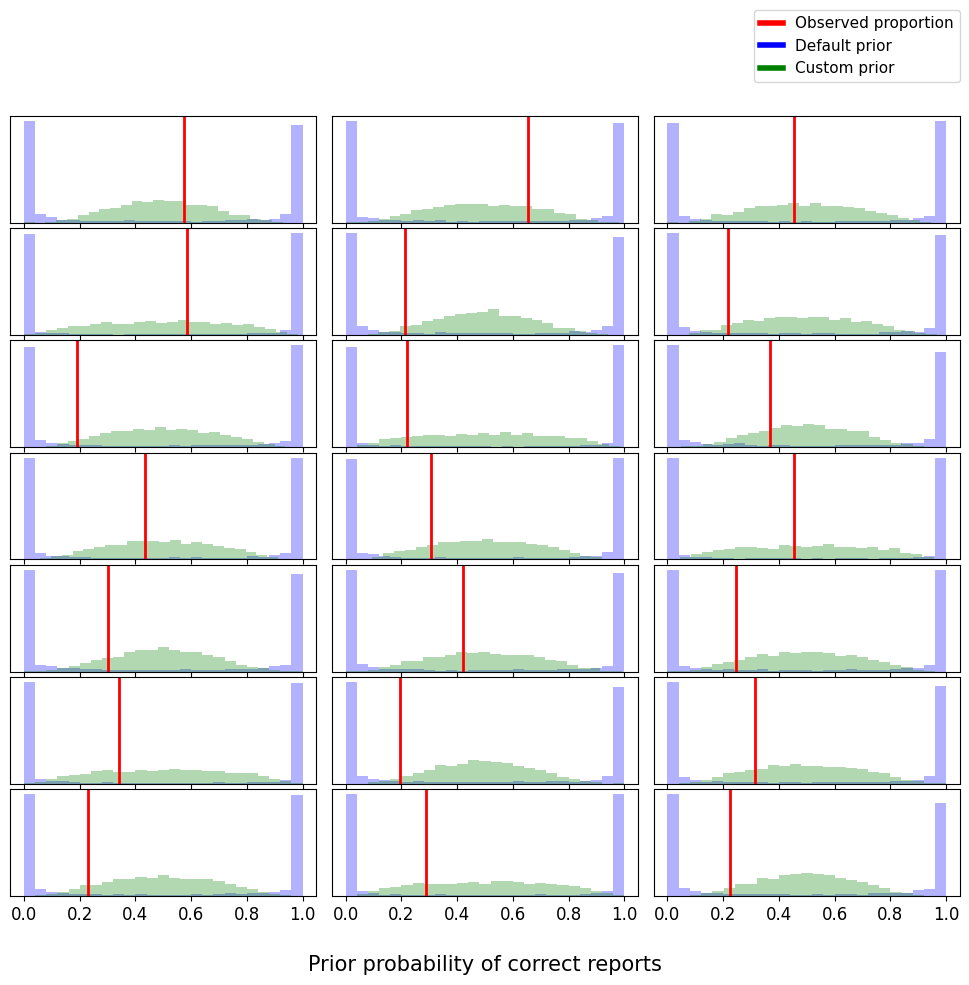

In [1]:
import arviz as az 
from plots import plot_prior_predictive
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('data/Dataset_DistractorInterference_agg.csv', sep=';', decimal=',') 
idata = az.from_netcdf('traces/DistractorInferference_trace.nc')                                   
default_prior = az.extract_dataset(idata, group='default_prior_predictive')['p(correct, count)']
custom_prior = az.extract_dataset(idata, group='prior_predictive')['p(correct, count)']

axs = plot_prior_predictive(data, default_prior)
axs = plot_prior_predictive(data, custom_prior, axes=axs, draw_data=False, color='green')

### 3) Traceplots

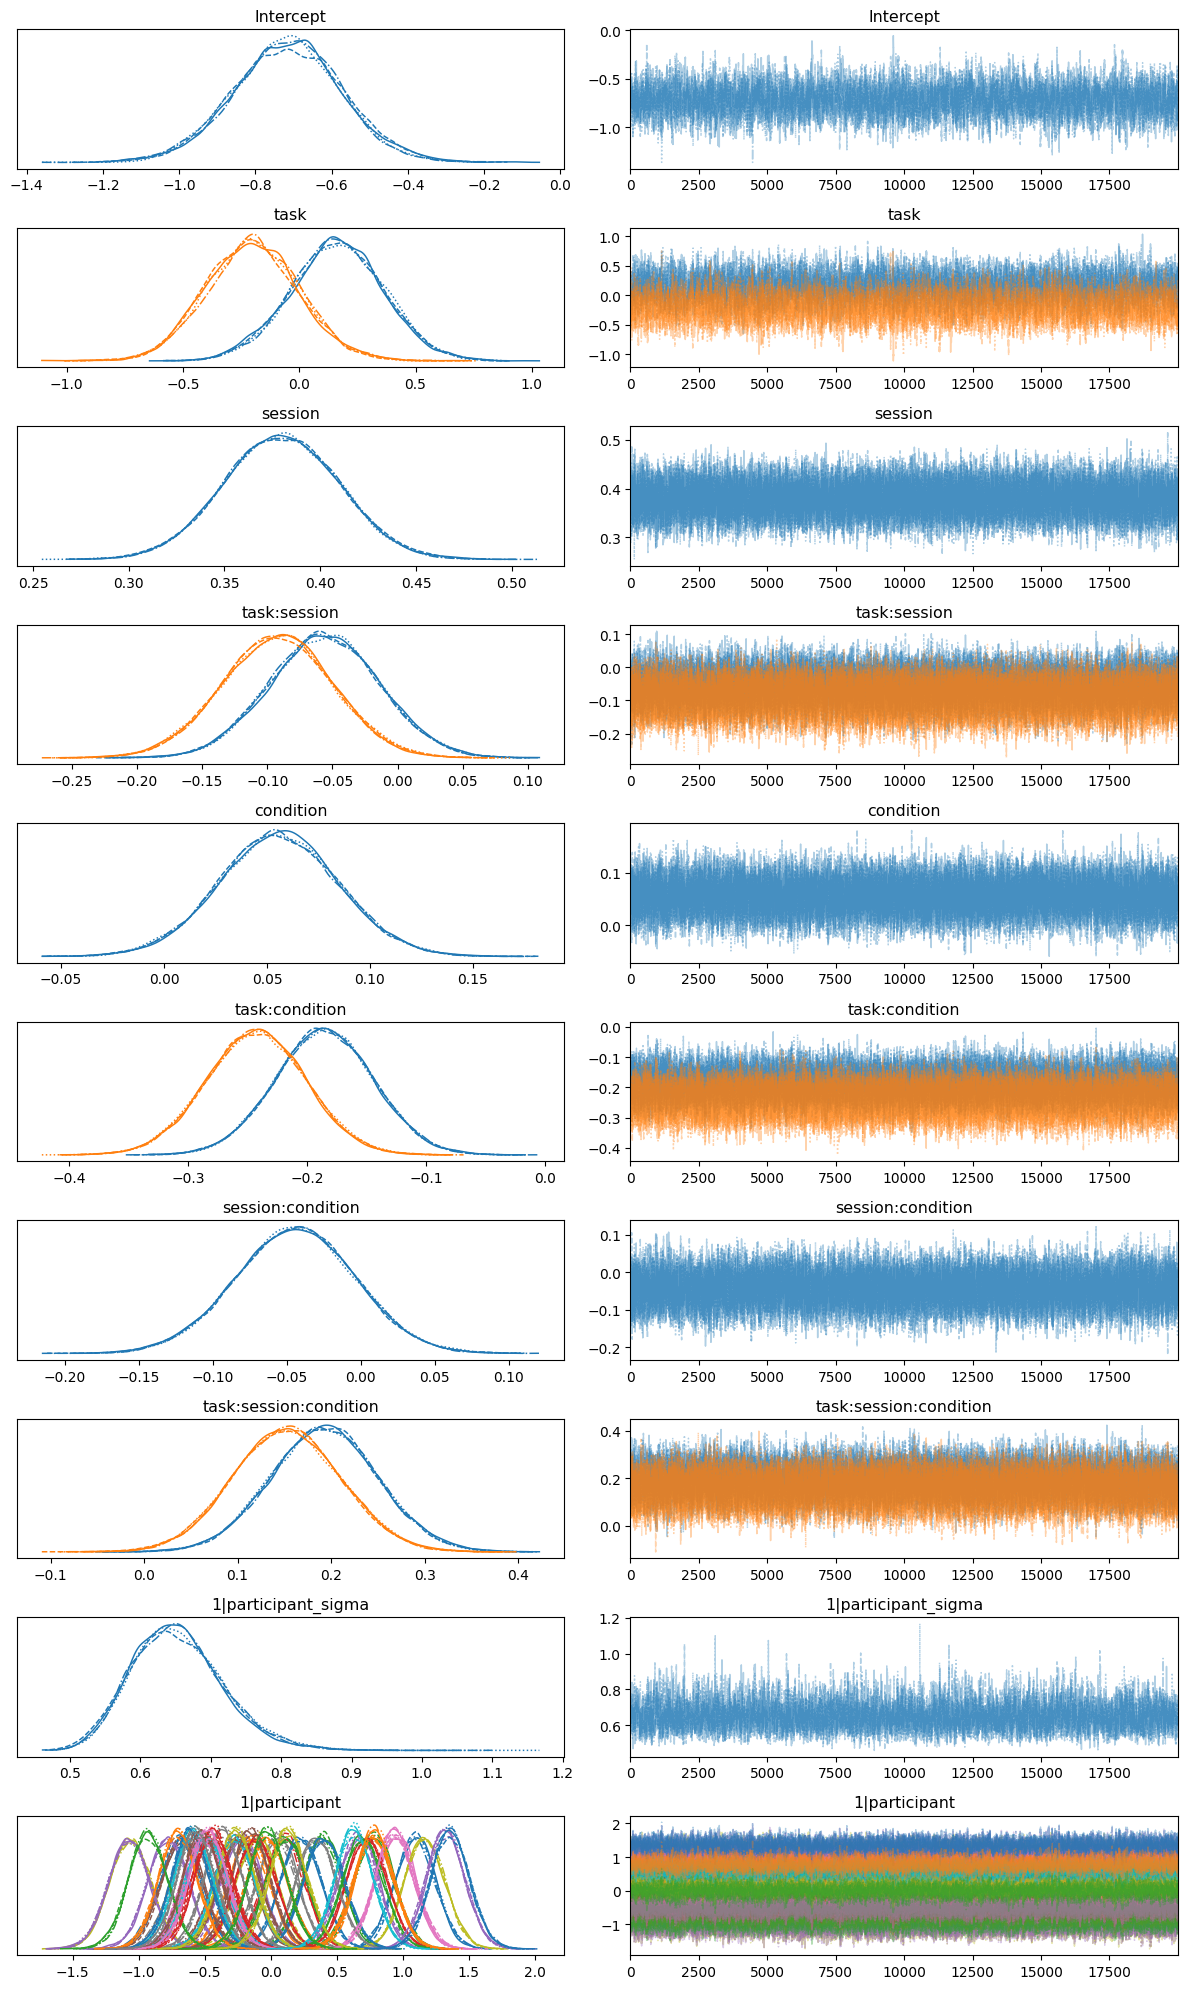

In [5]:
import arviz as az
from matplotlib.pylab import plt
import warnings
warnings.filterwarnings("ignore")

idata = az.from_netcdf('traces/DistractorInferference_trace.nc') 
az.plot_trace(idata, compact=True)
plt.tight_layout()

### 4) Get summary

In [1]:
import arviz as az
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
az.rcParams['stats.hdi_prob'] = 0.95

pd.set_option('display.max_rows', None)
idata = az.from_netcdf('traces/DistractorInferference_trace.nc') 
az.summary(idata)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.717,0.143,-1.002,-0.436,0.002,0.002,3286.0,5549.0,1.0
task[gray],0.162,0.201,-0.244,0.549,0.003,0.002,3721.0,6353.0,1.0
task[mixed],-0.201,0.202,-0.598,0.187,0.004,0.002,3294.0,5544.0,1.0
session[2],0.380,0.030,0.321,0.438,0.000,0.000,10938.0,21009.0,1.0
"task:session[gray, 2]",-0.056,0.042,-0.140,0.026,0.000,0.000,11555.0,22863.0,1.0
"task:session[mixed, 2]",-0.093,0.043,-0.176,-0.009,0.000,0.000,12119.0,21636.0,1.0
condition[present],0.056,0.029,-0.001,0.113,0.000,0.000,11333.0,20547.0,1.0
"task:condition[gray, present]",-0.185,0.041,-0.268,-0.106,0.000,0.000,11632.0,22918.0,1.0
"task:condition[mixed, present]",-0.243,0.042,-0.325,-0.161,0.000,0.000,12933.0,22210.0,1.0
"session:condition[2, present]",-0.044,0.040,-0.122,0.036,0.000,0.000,9824.0,17422.0,1.0


### 5) Compute predictions and comparisons

#### 5.1) Differences between present and absent across sessions

In [13]:
import arviz as az
import numpy as np
import pandas as pd
import xarray as xr
import bambi as bmb
from bambi.interpret.helpers import data_grid, select_draws
import warnings
bmb.config["INTERPRET_VERBOSE"] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

# Get data
data = pd.read_csv('data/Dataset_DistractorInterference_agg.csv', sep=';', decimal=',') 

# Define model
model = bmb.Model(
    'p(correct,count) ~ task*session*condition + (1 | participant)',
    data, family='binomial', categorical = ["session", "condition", "task", "participant"])

# Get idata
idata = az.from_netcdf('traces/DistractorInferference_trace.nc')

# Create data_grid
tasks = ["color", "gray", "mixed"]
sessions = [1, 2]
participants_mixed = np.arange(1, 19)
participants_gray = np.arange(19, 36)
participants_color = np.arange(36, 54 )

variables = {"condition": np.array(["present", "absent"])}

data_dict = {}
idata_dict = {}

for task in tasks:
    if task == "mixed":
        participants = participants_mixed
    elif task == "gray":
        participants = participants_gray
    else:
        participants = participants_color
            
    conditional = {"participant": participants, "session": sessions, "task": np.array([task])}
    key = f"{task}_data"
    data_dict[key] = data_grid(model, conditional, variables)
    idata_dict[key] = model.predict(idata, data=data_dict[key], inplace=False)
        


comparisons_list_conditions = []
hdi_diff_list_conditions = []

def calculate_stats(idata_dict, data_dict, task):
    key = f"{task}_data" 
    draws_session1_absent = select_draws(idata_dict[key], data_dict[key], {"session": 1, "condition": "absent"}, "p(correct, count)_mean")
    draws_session1_present = select_draws(idata_dict[key], data_dict[key], {"session": 1, "condition": "present"}, "p(correct, count)_mean")
    
    draws_session2_absent = select_draws(idata_dict[key], data_dict[key], {"session": 2, "condition": "absent"}, "p(correct, count)_mean")
    draws_session2_present = select_draws(idata_dict[key], data_dict[key], {"session": 2, "condition": "present"}, "p(correct, count)_mean")
        
       
    estimates =xr.concat([xr.concat([draws_session1_present,
               draws_session2_present],
              'Condition')\
        .mean(dim='Condition'),
        xr.concat([draws_session1_absent,
               draws_session2_absent],
              'Condition')\
        .mean(dim='Condition')],
        dim='Condition'
    ).rename('Estimates')
    
        
    # differences
    estimates_diff_conditions = (estimates.sel(Condition=0) - estimates.sel(Condition=1)).mean(dim='p(correct, count)_obs').values
    comparisons_list_conditions.append({"condition": "Δ (present, absent)", "task": task, "estimate": np.mean(estimates_diff_conditions)})
        
    # hdi
    hdi_diff_conditions = az.hdi((estimates.sel(Condition=0) - estimates.sel(Condition=1)).mean(dim='p(correct, count)_obs'), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
    hdi_diff_df_conditions = hdi_diff_conditions.to_dataframe(dim_order=None)
    hdi_diff_list_conditions.append(hdi_diff_df_conditions)
    
for task in tasks:
    calculate_stats(idata_dict, data_dict, task)

within_comparisons_df_conditions = pd.DataFrame(comparisons_list_conditions)

def extract_hdi_values(hdi_df):
    lower_value = hdi_df.loc['lower', 'Estimates']
    higher_value = hdi_df.loc['higher', 'Estimates']
    return lower_value, higher_value

for i, hdi_df in enumerate(hdi_diff_list_conditions):
    lower_col, higher_col = extract_hdi_values(hdi_df)
    within_comparisons_df_conditions.at[i, 'lower_2.5%'] = lower_col
    within_comparisons_df_conditions.at[i, 'upper_97.5%'] = higher_col
    
within_comparisons_df_conditions[['estimate', 'lower_2.5%', 'upper_97.5%']] *= 100
within_comparisons_df_conditions = within_comparisons_df_conditions.round({'estimate': 2, 'lower_2.5%': 2, 'upper_97.5%': 2})
    
display(within_comparisons_df_conditions)

,condition,task,estimate,lower_2.5%,upper_97.5%
0,"Δ (present, absent)",color,0.68,-0.16,1.50
1,"Δ (present, absent)",gray,-1.16,-2.05,-0.30
2,"Δ (present, absent)",mixed,-2.55,-3.36,-1.74


#### 5.2) Differences between tasks across sessions

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import xarray as xr
import bambi as bmb
from bambi.interpret.helpers import data_grid, select_draws
import warnings
bmb.config["INTERPRET_VERBOSE"] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

# Get data
data = pd.read_csv('data/Dataset_DistractorInterference_agg.csv', sep=';', decimal=',') 

# Define model
model = bmb.Model(
    'p(correct,count) ~ task*session*condition + (1 | participant)',
    data, family='binomial', categorical = ["session", "condition", "task", "participant"])


# Get idata
idata = az.from_netcdf('traces/DistractorInferference_trace.nc')


# Create data_grid
tasks = ["color", "gray", "mixed"]
sessions = [1, 2]
participants_mixed = np.arange(1, 19)
participants_gray = np.arange(19, 36)
participants_color = np.arange(36, 54 )

variables = {"condition": np.array(["present", "absent"])}

data_dict = {}
idata_dict = {}

for task in tasks:
    if task == "mixed":
        participants = participants_mixed
    elif task == "gray":
        participants = participants_gray
    else:
        participants = participants_color
            
    conditional = {"participant": participants, "session": sessions, "task": np.array([task])}
    key = f"{task}_data"
    data_dict[key] = data_grid(model, conditional, variables)
    idata_dict[key] = model.predict(idata, data=data_dict[key], inplace=False)
        

comparisons_list_conditions = []
hdi_diff_list_conditions = []


# mixed-feature task
draws_session1_absent_mixed = select_draws(idata_dict["mixed_data"], data_dict["mixed_data"], {"session": 1, "condition": "absent"}, "p(correct, count)_mean")
draws_session1_present_mixed = select_draws(idata_dict["mixed_data"], data_dict["mixed_data"], {"session": 1, "condition": "present"}, "p(correct, count)_mean")
    
draws_session2_absent_mixed = select_draws(idata_dict["mixed_data"], data_dict["mixed_data"], {"session": 2, "condition": "absent"}, "p(correct, count)_mean")
draws_session2_present_mixed = select_draws(idata_dict["mixed_data"], data_dict["mixed_data"], {"session": 2, "condition": "present"}, "p(correct, count)_mean")
    
estimates_mixed =xr.concat([xr.concat([draws_session1_present_mixed,
           draws_session2_present_mixed],
          'Condition')\
    .mean(dim='Condition'),
    xr.concat([draws_session1_absent_mixed,
           draws_session2_absent_mixed],
          'Condition')\
    .mean(dim='Condition')],
    dim='Condition'
).rename('Estimates')

# color fixed-feature task
draws_session1_absent_color = select_draws(idata_dict["color_data"], data_dict["color_data"], {"session": 1, "condition": "absent"}, "p(correct, count)_mean")
draws_session1_present_color = select_draws(idata_dict["color_data"], data_dict["color_data"], {"session": 1, "condition": "present"}, "p(correct, count)_mean")
    
draws_session2_absent_color = select_draws(idata_dict["color_data"], data_dict["color_data"], {"session": 2, "condition": "absent"}, "p(correct, count)_mean")
draws_session2_present_color = select_draws(idata_dict["color_data"], data_dict["color_data"], {"session": 2, "condition": "present"}, "p(correct, count)_mean")
    
estimates_color =xr.concat([xr.concat([draws_session1_present_color,
           draws_session2_present_color],
          'Condition')\
    .mean(dim='Condition'),
    xr.concat([draws_session1_absent_color,
           draws_session2_absent_color],
          'Condition')\
    .mean(dim='Condition')],
    dim='Condition'
).rename('Estimates')


#gray fixed-feature task
draws_session1_absent_gray = select_draws(idata_dict["gray_data"], data_dict["gray_data"], {"session": 1, "condition": "absent"}, "p(correct, count)_mean")
draws_session1_present_gray = select_draws(idata_dict["gray_data"], data_dict["gray_data"], {"session": 1, "condition": "present"}, "p(correct, count)_mean")
    
draws_session2_absent_gray = select_draws(idata_dict["gray_data"], data_dict["gray_data"], {"session": 2, "condition": "absent"}, "p(correct, count)_mean")
draws_session2_present_gray = select_draws(idata_dict["gray_data"], data_dict["gray_data"], {"session": 2, "condition": "present"}, "p(correct, count)_mean")
    
estimates_gray =xr.concat([xr.concat([draws_session1_present_gray,
           draws_session2_present_gray],
          'Condition')\
    .mean(dim='Condition'),
    xr.concat([draws_session1_absent_gray,
           draws_session2_absent_gray],
          'Condition')\
    .mean(dim='Condition')],
    dim='Condition'
).rename('Estimates')
    
    
# within-comparisons
estimates_diff_mixed = (estimates_mixed.sel(Condition=0) - estimates_mixed.sel(Condition=1))
estimates_diff_color = (estimates_color.sel(Condition=0) - estimates_color.sel(Condition=1))
estimates_diff_gray = (estimates_gray.sel(Condition=0) - estimates_gray.sel(Condition=1))
 
#between-tasks comparisons
estimates_diff_mixed_color = (estimates_diff_mixed - estimates_diff_color).mean(dim='p(correct, count)_obs').values
comparisons_list_conditions.append({"condition": "Δ (present, absent)", "task": "Δ (mixed, color)", "estimate": np.mean(estimates_diff_mixed_color)})
hdi_diff_mixed_color = az.hdi((estimates_diff_mixed - estimates_diff_color).mean(dim='p(correct, count)_obs'), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
hdi_diff_mixed_color_df = hdi_diff_mixed_color.to_dataframe(dim_order=None)
hdi_diff_list_conditions.append(hdi_diff_mixed_color_df) 
    
estimates_diff_mixed_gray = (estimates_diff_mixed - estimates_diff_gray).mean(dim='p(correct, count)_obs').values
comparisons_list_conditions.append({"condition": "Δ (present, absent)", "task": "Δ (mixed, gray)", "estimate": np.mean(estimates_diff_mixed_gray)})
hdi_diff_mixed_gray = az.hdi((estimates_diff_mixed - estimates_diff_gray).mean(dim='p(correct, count)_obs'), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
hdi_diff_mixed_gray_df = hdi_diff_mixed_gray.to_dataframe(dim_order=None)
hdi_diff_list_conditions.append(hdi_diff_mixed_gray_df)  
       
estimates_diff_gray_color = (estimates_diff_gray - estimates_diff_color).mean(dim='p(correct, count)_obs').values
comparisons_list_conditions.append({"condition": "Δ (present, absent)", "task": "Δ (gray, color)", "estimate": np.mean(estimates_diff_gray_color)})
hdi_diff_gray_color = az.hdi((estimates_diff_gray - estimates_diff_color).mean(dim='p(correct, count)_obs'), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
hdi_diff_gray_color_df = hdi_diff_gray_color.to_dataframe(dim_order=None)
hdi_diff_list_conditions.append(hdi_diff_gray_color_df) 

between_comparisons_df_conditions = pd.DataFrame(comparisons_list_conditions)

def extract_hdi_values(hdi_df):
    lower_value = hdi_df.loc['lower', 'Estimates']
    higher_value = hdi_df.loc['higher', 'Estimates']
    return lower_value, higher_value
                                   
for i, hdi_df in enumerate(hdi_diff_list_conditions):
    lower_col, higher_col = extract_hdi_values(hdi_df)
    between_comparisons_df_conditions.at[i, 'lower_2.5%'] = lower_col
    between_comparisons_df_conditions.at[i, 'upper_97.5%'] = higher_col
    
between_comparisons_df_conditions[['estimate', 'lower_2.5%', 'upper_97.5%']] *= 100
between_comparisons_df_conditions = between_comparisons_df_conditions.round({'estimate': 2})
between_comparisons_df_conditions = between_comparisons_df_conditions.round({'estimate': 2, 'lower_2.5%': 2, 'upper_97.5%': 2})
    
display(between_comparisons_df_conditions)

,condition,task,estimate,lower_2.5%,upper_97.5%
0,"Δ (present, absent)","Δ (mixed, color)",-3.23,-4.40,-2.08
1,"Δ (present, absent)","Δ (mixed, gray)",-1.42,-2.59,-0.19
2,"Δ (present, absent)","Δ (gray, color)",-1.84,-3.03,-0.63


#### 5.3) Differences within sessions

In [12]:
import arviz as az
import numpy as np
import pandas as pd
import xarray as xr
import bambi as bmb
from bambi.interpret.helpers import data_grid, select_draws
import warnings
bmb.config["INTERPRET_VERBOSE"] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

# Get data
data = pd.read_csv('data/Dataset_DistractorInterference_agg.csv', sep=';', decimal=',') 

# Define model
model = bmb.Model(
    'p(correct,count) ~ task*session*condition + (1| participant)',
    data, family='binomial', categorical = ["session", "condition", "task", "participant"])


# Get idata
idata = az.from_netcdf('traces/DistractorInferference_trace.nc')

# Create data_grid
tasks = ["color", "gray", "mixed"]
sessions = [1, 2]
participants_mixed = np.arange(1, 19) #Only participants who are actually in the task are included 
participants_gray = np.arange(19, 36)
participants_color = np.arange(36, 54 )

variables = {"condition": np.array(["present", "absent"])}

data_dict = {}
idata_dict = {}

for task in tasks:
    for session in sessions:
        if task == "mixed":
            participants = participants_mixed
        elif task == "gray":
            participants = participants_gray
        else:
            participants = participants_color
            
        conditional = {"participant": participants, "session": np.array([session]), "task": np.array([task])}
        key = f"{task}_session{session}_data"
        data_dict[key] = data_grid(model, conditional, variables)
        idata_dict[key] = model.predict(idata, data=data_dict[key], inplace=False)
        

results_list = []
comparisons_list = []
hdi_present_list = []
hdi_absent_list = []
hdi_diff_list = []

def calculate_stats(idata_dict, data_dict, session, task):
    key = f"{task}_session{session}_data"
    draws_present = select_draws(idata_dict[key], data_dict[key], {"condition": "present"}, "p(correct, count)_mean")
    draws_absent = select_draws(idata_dict[key], data_dict[key], {"condition": "absent"}, "p(correct, count)_mean")

    draws_absent_mean = draws_absent.mean("p(correct, count)_obs").values
    draws_present_mean = draws_present.mean("p(correct, count)_obs").values
    
    results_list.append({"session": session, "condition": "absent", "task": task, "estimate": np.mean(draws_absent_mean)})
    results_list.append({"session": session, "condition": "present", "task": task, "estimate": np.mean(draws_present_mean)})
        
    # hdi present condition
    hdi_present = az.hdi(draws_present.mean("p(correct, count)_obs"), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
    hdi_present_df = hdi_present.to_dataframe(dim_order=None)
    hdi_present_list.append(hdi_present_df)
    
    # hdi absent condition
    hdi_absent = az.hdi(draws_absent.mean("p(correct, count)_obs"), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
    hdi_absent_df = hdi_absent.to_dataframe(dim_order=None)
    hdi_absent_list.append(hdi_absent_df)
    
    
    # Difference between present and absent within sessions
    diff_present_absent_mean = (draws_present - draws_absent).mean("p(correct, count)_obs").values
    comparisons_list.append({"session": session, "condition": "Δ (present, absent)", "task": task, "estimate": np.mean(diff_present_absent_mean)})
    
    hdi_diff = az.hdi((draws_present - draws_absent).mean("p(correct, count)_obs"), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
    hdi_diff_df = hdi_diff.to_dataframe(dim_order=None)
    hdi_diff_list.append(hdi_diff_df)
    

for session in sessions:
    for task in tasks:
        calculate_stats(idata_dict, data_dict, session, task)

estimates_df = pd.DataFrame(results_list)
estimates_df = estimates_df.sort_values(by=['session', 'condition']).reset_index(drop=True)

within_comparisons_df = pd.DataFrame(comparisons_list)
within_comparisons_df = within_comparisons_df.sort_values(by=['session']).reset_index(drop=True)

present_indices = estimates_df[estimates_df['condition'] == 'present'].index
absent_indices = estimates_df[estimates_df['condition'] == 'absent'].index
        
    
def extract_hdi_values(hdi_df):
    lower_value = hdi_df.loc['lower', 'p(correct, count)_mean']
    higher_value = hdi_df.loc['higher', 'p(correct, count)_mean']
    return lower_value, higher_value

for present_index, hdi_df in zip(present_indices, hdi_present_list):
    lower_col, higher_col = extract_hdi_values(hdi_df)
    estimates_df.at[present_index, 'lower_2.5%'] = lower_col
    estimates_df.at[present_index, 'upper_97.5%'] = higher_col

for absent_index, hdi_df in zip(absent_indices, hdi_absent_list):
    lower_col, higher_col = extract_hdi_values(hdi_df)
    estimates_df.at[absent_index, 'lower_2.5%'] = lower_col
    estimates_df.at[absent_index, 'upper_97.5%'] = higher_col
    
for i, hdi_df in enumerate(hdi_diff_list):
    lower_col, higher_col = extract_hdi_values(hdi_df)
    within_comparisons_df.at[i, 'lower_2.5%'] = lower_col
    within_comparisons_df.at[i, 'upper_97.5%'] = higher_col
      

# Difference between present and absent; between sessions
between_session_comparisons_list = []
hdi_between_session_comparisons_list = []

draws_present_mixed1 = select_draws(idata_dict[f"mixed_session{1}_data"], data_dict[f"mixed_session{1}_data"], {"condition": "present"}, "p(correct, count)_mean")
draws_absent_mixed1 = select_draws(idata_dict[f"mixed_session{1}_data"], data_dict[f"mixed_session{1}_data"], {"condition": "absent"}, "p(correct, count)_mean")
diff_present_absent_mixed1 = (draws_present_mixed1 - draws_absent_mixed1)

draws_present_mixed2 = select_draws(idata_dict[f"mixed_session{2}_data"], data_dict[f"mixed_session{2}_data"], {"condition": "present"}, "p(correct, count)_mean")
draws_absent_mixed2 = select_draws(idata_dict[f"mixed_session{2}_data"], data_dict[f"mixed_session{2}_data"], {"condition": "absent"}, "p(correct, count)_mean")
diff_present_absent_mixed2 = (draws_present_mixed2 - draws_absent_mixed2)

between_session_comparisons_mixed = (diff_present_absent_mixed1 - diff_present_absent_mixed2).mean("p(correct, count)_obs").values
between_session_comparisons_list.append({"session": "Δ (1, 2)", "condition": "Δ (present, absent)", "task": "mixed", "estimate": np.mean(between_session_comparisons_mixed)})
between_session_comparisons_df = pd.DataFrame(between_session_comparisons_list)

# HDI
hdi_between_session_comparisons_mixed = az.hdi((diff_present_absent_mixed1 - diff_present_absent_mixed2).mean("p(correct, count)_obs"), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)   
hdi_between_session_comparisons_df_mixed = hdi_between_session_comparisons_mixed.to_dataframe(dim_order=None)
hdi_between_session_comparisons_list.append(hdi_between_session_comparisons_df_mixed)


for i, hdi_df in enumerate(hdi_between_session_comparisons_list):
    lower_col, higher_col = extract_hdi_values(hdi_df)
    between_session_comparisons_df.at[i, 'lower_2.5%'] = lower_col
    between_session_comparisons_df.at[i, 'upper_97.5%'] = higher_col


estimates_df[['estimate', 'lower_2.5%', 'upper_97.5%']] *= 100
estimates_df = estimates_df.round({'estimate': 2, 'lower_2.5%': 2, 'upper_97.5%': 2})

within_comparisons_df[['estimate', 'lower_2.5%', 'upper_97.5%']] *= 100
within_comparisons_df = within_comparisons_df.round({'estimate': 2, 'lower_2.5%': 2, 'upper_97.5%': 2})

between_session_comparisons_df[['estimate', 'lower_2.5%', 'upper_97.5%']] *= 100
between_session_comparisons_df = between_session_comparisons_df.round({'estimate': 2, 'lower_2.5%': 2, 'upper_97.5%': 2})

display(estimates_df)
display(within_comparisons_df)
display(between_session_comparisons_df)

,session,condition,task,estimate,lower_2.5%,upper_97.5%
0,1,absent,color,33.69,32.84,34.56
1,1,absent,gray,37.52,36.62,38.45
2,1,absent,mixed,29.05,28.21,29.89
3,1,present,color,34.81,34.05,35.60
4,1,present,gray,34.77,33.97,35.58
5,1,present,mixed,25.59,24.86,26.31
6,2,absent,color,41.60,40.70,42.48
7,2,absent,gray,44.67,43.72,45.59
8,2,absent,mixed,34.84,33.97,35.74
9,2,present,color,41.84,41.06,42.66


,session,condition,task,estimate,lower_2.5%,upper_97.5%
0,1,"Δ (present, absent)",color,1.12,-0.01,2.29
1,1,"Δ (present, absent)",gray,-2.75,-3.98,-1.53
2,1,"Δ (present, absent)",mixed,-3.46,-4.56,-2.34
3,2,"Δ (present, absent)",color,0.25,-0.95,1.44
4,2,"Δ (present, absent)",gray,0.42,-0.82,1.69
5,2,"Δ (present, absent)",mixed,-1.64,-2.83,-0.48


,session,condition,task,estimate,lower_2.5%,upper_97.5%
0,"Δ (1, 2)","Δ (present, absent)",mixed,-1.82,-3.47,-0.22


### 6) Plot predictions

Please note that the following cell must be run together with the previous cell.

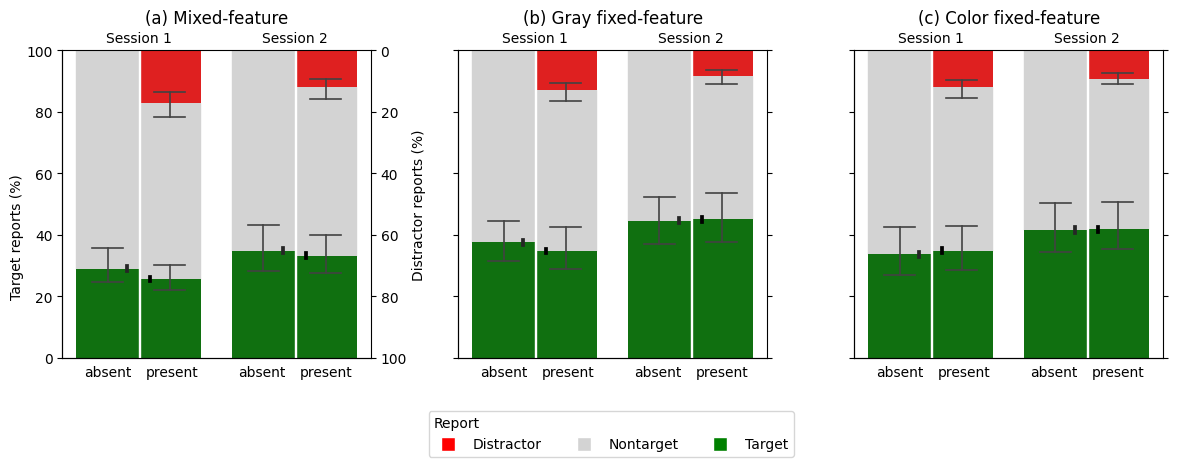

In [11]:
from os import path
import warnings
import arviz as az
import bambi as bmb
import pandas as pd
import seaborn as sns
import pymc as pm
import numpy as np
from pandas.api.types import CategoricalDtype
from matplotlib.pylab import plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import scipy
from scikits import bootstrap
warnings.filterwarnings("ignore")


data = pd.read_csv('data/Dataset_DistractorInterference_agg.csv', sep=';', decimal=',') 
data['report frequency target (%)'] = (data['correct'] / data['count'])*100
data['report frequency distractor (%)'] = (data['distractor_reports'] / data['count'])*100

model = bmb.Model(
    'p(correct,count) ~ task*session*condition + (1 | participant)',
    data, family='binomial', categorical = ["session", "condition", "task", "participant"])


# Get idata
idata = az.from_netcdf('traces/DistractorInferference_trace.nc')

palette ={"absent": "green", "present": "green"}
width = 0.4


# Plot observed data 
def custom_barplot(x,y,hue,color,**kwargs):
    ax1 = plt.gca()
    sns.barplot(x=x, y=y, hue=hue, color=color, **kwargs, ax=ax1)
    ax1.set(ylim=(0,100))
    ax1.zorder=0                 

def twin_barplot(x,y,hue,color,**kwargs):
    ax2 = plt.twinx()
    ax2.set(ylim=(0,100))
    ax2.invert_yaxis()
    sns.barplot(x=x, y=y, hue=hue, color=color, **kwargs, ax=ax2)
    ax2.legend_.remove()
    ax2.zorder=1
    
g = sns.FacetGrid(data, col='task', height=4, col_order = ["color", "gray", "mixed"], )

target_plot = g.map(custom_barplot, 'session', 'report frequency target (%)', 'condition', palette=palette, errorbar=lambda y: bootstrap.ci(y, statfunction=lambda x: np.mean(x, axis=0), method='bca'), capsize=0.2, errwidth=1.2)
distractor_plot = g.map(twin_barplot, 'session', 'report frequency distractor (%)', 'condition', color = "red", errorbar=lambda y: bootstrap.ci(y, statfunction=lambda x: np.mean(x, axis=0), method='bca'), capsize=0.2, errwidth=1.2)


# Set x-axis labels on top
for ax in g.axes.flat:
    ax.xaxis.set_ticks_position('top')

    
# Plot predictions
def get_hdi(x):
    row = task_data[np.isclose(task_data['estimate'], x.values[0])]
    return (row['lower_2.5%'].values[0], row['upper_97.5%'].values[0])

for ax, task in zip(g.axes.flat, ["color", "gray", "mixed"]):
    task_data = estimates_df[estimates_df['task'] == task]
    task_data = pd.concat([task_data, task_data]).reset_index(drop=True)
    sns.pointplot(x='session', y='estimate', hue='condition', color='black', ax=ax, data=task_data, errorbar=lambda x: get_hdi(x), join=False, dodge=.15, scale=0.1)
    ax.legend_.remove()

    
#Plot nontargets
positions = {'absent_1' : 0-width,
             'present_1' : 0-0.004,
             'absent_2' : 1-width,
             'present_2' : 1-0.004            
            }

for i,task in enumerate(['color', 'gray', 'mixed']):
    for session in [1,2]:
        for condition in ['absent', 'present']:
            data_ = data.query('task==@task and session==@session and condition==@condition')
            y_start = data_['report frequency target (%)'].mean()
            y_end = 100 - data_['report frequency distractor (%)'].mean() - y_start
            x_start = positions['%s_%d'%(condition, session)]
            g.axes[0][i].add_patch(
                Rectangle((x_start, y_start), width,y_end, color='lightgray', zorder=-1)
            )
            

# change/remove labels
plt.figure(1).axes[0].get_yaxis().get_label().set(text='')

plt.figure(1).axes[0].set_title("(c) Color fixed-feature")
plt.figure(1).axes[0].tick_params(left = True, labelleft = False)
plt.figure(1).axes[0].set_xlabel('')
plt.figure(1).axes[1].set_title("(b) Gray fixed-feature")
plt.figure(1).axes[1].set_xlabel('')
plt.figure(1).axes[2].set_title("(a) Mixed-feature")
plt.figure(1).axes[2].tick_params(left = True, labelleft = True)

tick_labels = ['Session 1', 'Session 2']
plt.figure(1).axes[2].set_xticklabels(tick_labels)
plt.figure(1).axes[2].set_xlabel('')

y=-0.06

for i in [0, 1, 2]:
    plt.figure(1).axes[i].text(0.07, y, 'absent', transform=plt.figure(1).axes[i].transAxes)
    plt.figure(1).axes[i].text(0.57, y, 'absent', transform=plt.figure(1).axes[i].transAxes)
    plt.figure(1).axes[i].text(0.27, y, 'present', transform=plt.figure(1).axes[i].transAxes)
    plt.figure(1).axes[i].text(0.77, y, 'present', transform=plt.figure(1).axes[i].transAxes)
    plt.figure(1).axes[i].tick_params(axis='x',length=0)
    

plt.figure(1).axes[3].get_yaxis().get_label().set(text='')
plt.figure(1).axes[4].get_yaxis().get_label().set(text='')
plt.figure(1).axes[5].get_yaxis().get_label().set(position=(437.3, 0.5), text='Distractor reports (%)')

plt.figure(1).axes[3].set(position=[0.7, 0.1457, 0.257, 0.7685])
plt.figure(1).axes[3].tick_params(right = True, labelright = False)
plt.figure(1).axes[4].set(position=[0.37, 0.1457, 0.257, 0.7685])
plt.figure(1).axes[4].tick_params(right = True, labelright = False)
plt.figure(1).axes[5].set(position=[0.04, 0.1457, 0.257, 0.7685])
plt.figure(1).axes[5].text(-0.17, 0.2, 'Target reports (%)', transform=plt.figure(1).axes[5].transAxes, rotation=90.) 

#Add white line between barplots
for i in [3, 4, 5]:
    ax = plt.figure(1).axes[i]
    for x in [0, 1]:
        ax.add_patch(Rectangle((x, 0), 0.01, 100, color='white', zorder=2))

# Create a custom legend
legend_labels = ['Distractor', 'Nontarget', 'Target']
custom_legend = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='red', markersize=10, label=legend_labels[0]),
                 plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='lightgray', markersize=10, label=legend_labels[1]),
                 plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='green', markersize=10, label=legend_labels[2])]

# Add legend
plt.legend(handles=custom_legend, loc='upper center', bbox_to_anchor=(1.78, -0.15), title='Report', ncol=3, frameon=True, alignment="left")
_=plt.plot()